# Overview


This notebook is created for solving the [Kaggle House Price Modeling Challenge](https://www.kaggle.com/competitions/house-prices-advanced-regression-techniques). The dataset has various categorical (nominal, binary, and ordinal variables) and numerical variables to determine the selling price of a house. The training dataset is rather small (1460) and it has a lot of variables (81). The lack of data and the huge number of variables was a pretty big challenge in this competition.

This notebook is my first base model to solving the problem. I perform a bit of EDA (exploratory data analysis) and I cycle through several models such as Linear Regression all the way to Xgboost and I also use a bit of model stacking to optimize model performance. 



# Good Notebooks to follow

Score 0.1064 https://www.kaggle.com/code/masumrumi/a-detailed-regression-guide-with-house-pricing <br>
Score 0.1184 https://www.kaggle.com/code/lavanyashukla01/how-i-made-top-0-3-on-a-kaggle-competition <br>
Score: 0.1197 https://www.kaggle.com/code/pablocorralgutirrez/house-prices-regressor <br>
Score 0.122 https://www.kaggle.com/code/ahmedgouda8wo/top6-rmse-0-12200-house-price-prediction 

## Table of Contents

1. [Utility Functions](#utility)
2. [Handling Missing Values](#missing_values)
3. [Understanding Target Variable](#target)
4. [Modeling](#modeling)

In [1]:
import sys
 
sys.path.append('C:\\Users\\Nikhil\\Data_Science_Projects')
from common_ds_modules import missing_values, data_manipulation, modeling
import os
import pandas as pd
import numpy as np
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression
import seaborn as sns
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
import pickle
from sklearn.linear_model import Lasso, Ridge, ElasticNet
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import StackingRegressor

C:\Users\Nikhil\anaconda3\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


### Utility Functions <a id='utility'></a>

In [2]:
def get_column(df, query=''):
    for c in df.columns:
        if query.lower() in c.lower():
            print(f'Column: {c}')

In [3]:
MAX_MODELS = 100

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
train_df['MSSubClass'] = train_df['MSSubClass'].apply(lambda x: str(x))
test_df['MSSubClass'] = test_df['MSSubClass'].apply(lambda x: str(x))
train_df['LogSalePrice'] = np.log(train_df['SalePrice'] + 1)


### Fill in Missing Values <a id='missing_values'></a>

In [6]:
rename_columns = {'1stFlrSF': 'FirstFlrSF', '2ndFlrSF':'SecondFlrSF', '3SsnPorch':'ThreeSeasonPorch'} 
    

train_df = train_df.rename(rename_columns, axis='columns')
test_df = test_df.rename(rename_columns, axis='columns')

Getting rid of all columns that have more than 30% missing values. I chose 30 as a rather arbitrary number, I thought it was just right, if it is more than 30, then you will corrupt the variable distribution with the fill in value. 

For categorical variables I fill in missing values by using the mode, and for numerical variables I use the mean.

In [7]:
train_drop = missing_values.get_high_missing_value_columns(train_df, 30)
test_drop = missing_values.get_high_missing_value_columns(test_df, 30)


train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')

This function gets the numerical and categorical variables, and fills in missing values as well.

In [8]:
numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_low_missing_vals_df,\
                                                                                            test_low_missing_vals_df, 'Id')
                                                                                                   

Sanity check to make sure that training and testing dataset don't have any columns with missing values after fill in.

In [9]:
missing_values.get_null_columns(train_low_missing_vals_df)
missing_values.get_null_columns(test_low_missing_vals_df)

In [10]:
def plot_variable_dist(df, variables):
    for c in variables:
        plt.hist(train_df[c])
        plt.title(f'Distribution for {c}')
        plt.show()

## Understanding the target variable <a id='target'></a>

For this problem I am trying to predict the SalePrice, so that is the target. In this section I will create a few plots to examine the SalePrice variable

In [11]:
target = 'SalePrice'

C:\Users\Nikhil\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


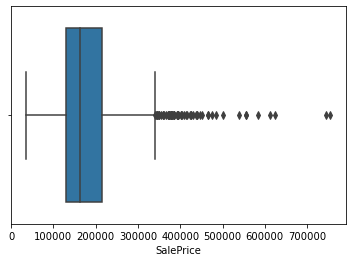

In [12]:
sns.boxplot(train_df[target])
plt.show()

In [13]:
q1 = np.percentile(train_df[target], 25)
q3 = np.percentile(train_df[target], 75)
iqr = q3 - q1
max_outlier = q3+1.5*iqr
print(f'Max outlier: {max_outlier}')
num_outliers = train_df[train_df['SalePrice'] > max_outlier].shape[0]
print(f'Percentage of outliers: {100*round(num_outliers/train_df.shape[0], 2)}')

Max outlier: 340037.5
Percentage of outliers: 4.0


#### Histogram of Sale Price

(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

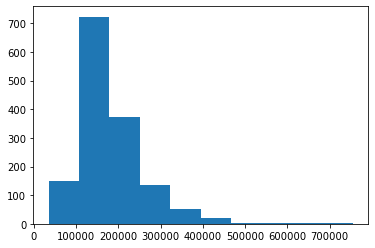

In [14]:
plt.hist(train_df['SalePrice'])

In [15]:
label = 'SalePrice'

### Correlation Matrix for all numerical variables

In [16]:
corr = train_df.corr()[label].sort_values()
valid_correlations = corr[(corr > 0.4) & (corr < 1)].index.tolist()
train_df[valid_correlations].corr()

,Fireplaces,MasVnrArea,GarageYrBlt,YearRemodAdd,YearBuilt,TotRmsAbvGrd,FullBath,FirstFlrSF,TotalBsmtSF,GarageArea,GarageCars,GrLivArea,OverallQual,LogSalePrice
Fireplaces,1.000000,0.249070,0.046822,0.112581,0.147716,0.326114,0.243671,0.410531,0.339519,0.269141,0.300789,0.461679,0.396765,0.489450
MasVnrArea,0.249070,1.000000,0.252691,0.179618,0.315707,0.280682,0.276833,0.344501,0.363936,0.373066,0.364204,0.390857,0.411876,0.430809
GarageYrBlt,0.046822,0.252691,1.000000,0.642277,0.825667,0.148112,0.484557,0.233449,0.322445,0.564567,0.588920,0.231197,0.547766,0.541073
YearRemodAdd,0.112581,0.179618,0.642277,1.000000,0.592855,0.191740,0.439046,0.240379,0.291066,0.371600,0.420622,0.287389,0.550684,0.565608
YearBuilt,0.147716,0.315707,0.825667,0.592855,1.000000,0.095589,0.468271,0.281986,0.391452,0.478954,0.537850,0.199010,0.572323,0.586570
TotRmsAbvGrd,0.326114,0.280682,0.148112,0.191740,0.095589,1.000000,0.554784,0.409516,0.285573,0.337822,0.362289,0.825489,0.427452,0.534422
FullBath,0.243671,0.276833,0.484557,0.439046,0.468271,0.554784,1.000000,0.380637,0.323722,0.405656,0.469672,0.630012,0.550600,0.594771
FirstFlrSF,0.410531,0.344501,0.233449,0.240379,0.281986,0.409516,0.380637,1.000000,0.819530,0.489782,0.439317,0.566024,0.476224,0.596981
TotalBsmtSF,0.339519,0.363936,0.322445,0.291066,0.391452,0.285573,0.323722,0.819530,1.000000,0.486665,0.434585,0.454868,0.537808,0.612134
GarageArea,0.269141,0.373066,0.564567,0.371600,0.478954,0.337822,0.405656,0.489782,0.486665,1.000000,0.882475,0.468997,0.562022,0.650888


In [17]:
# compartmentalize in another program

In [18]:
y_train = train_low_missing_vals_df['LogSalePrice']
train_model_data, test_model_data = data_manipulation.get_train_test_model_data(train_low_missing_vals_df, test_low_missing_vals_df,\
                                                                                numerical_variables, categorical_variables,\
                                                                                'SalePrice', target2='LogSalePrice')

train_drop_columns = list(set(train_model_data.columns) - set(test_model_data.columns))
train_model_data_final = train_model_data.drop(train_drop_columns, axis='columns')

## Modeling <a id='modeling'></a>

### Default random forest regressor

In [1]:
import pickle

In [2]:
%%time
rf_model_default = RandomForestRegressor().fit(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, rf_model_default)
filename = 'rf_default_model.pkl'
pickle.dump(rf_model_default, open(filename, 'wb'))


NameError: name 'RandomForestRegressor' is not defined

In [3]:
#modeling section in new program

### RandomForest Regressor

In [4]:
%%time
rf_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'min_samples_split':[20, 30],
    'min_samples_leaf':[20, 30]
}

rf_model = modeling.get_random_forest_regressor_results(train_model_data_final, y_train, param_grid=rf_param_grid, test=None, y_test=None)

model = RandomForestRegressor(**rf_model.best_params_).fit(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train,model)

NameError: name 'modeling' is not defined

### Decision Tree

In [5]:
%%time

dt_param_grid = {
    'max_depth':[2,3],
    'min_samples_split':[50, 30],
    'min_samples_leaf':[50, 30],
    'max_features' : [30, 40],
    'min_impurity_decrease': [i/100 for i in range(1, 3)],
    'ccp_alpha': [i/10 for i in range(1, 3)]
}

dt_model = modeling.get_decision_tree_model(train_model_data_final, y_train, dt_param_grid)
modeling.evaluate(train_model_data_final, y_train, dt_model)

NameError: name 'modeling' is not defined

###  XGBRegressor

In [6]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(1, 3)],
    'min_child_weight': [10*i for i in range(1,3)],
    'learning_rate': [i/100 for i in range(1,3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)

xgb_regressor = XGBRegressor(**xgb_model.best_params_)
scores = cross_val_score(xgb_regressor, train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}, std RMSLE = {np.std(scores)}')

from sklearn.metrics import mean_squared_error, mean_squared_log_error, mean_absolute_error

xgb_regressor = XGBRegressor(**xgb_model.best_params_).fit(train_model_data_final, y_train)
train_pred = xgb_regressor.predict(train_model_data_final)
train_pred = np.exp(train_pred) - 1
print(f'MAE = {mean_absolute_error(train_df["SalePrice"], train_pred)}')
print(f'RMSLE = {np.sqrt(mean_squared_error(train_df["SalePrice"], train_pred))}')
test_pred = xgb_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('xgb_predicted.csv', index=False)

NameError: name 'modeling' is not defined

### Linear Regression

In [7]:
lr_model = modeling.get_linear_regressor_model(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, lr_model)

NameError: name 'modeling' is not defined

### Ridge Regression

In [ ]:
%%time
ridge_param_grid = {
    'alpha':[i/100 for i in range(1, 6)] + [i/10 for i in range(1, 6)] + [i*10 for i in range(1, 6)] + [i*100 for i in range(1, 6)]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

In [ ]:
%%time
ridge_param_grid = {
    'alpha':[i*100 for i in range(4, 11)]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

### Lasso Regression

In [ ]:
%%time
lasso_param_grid = {
    'alpha':[i/100 for i in range(1, 3)]
}
lasso_gs = modeling.get_lasso_regression_model(train_model_data_final, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
scores = cross_val_score(lasso, scaler.transform(train_model_data_final), y_train, scoring='neg_root_mean_squared_error', cv=5)
print(f'mean RMSLE = {-np.mean(scores)}')

### Elastic Net Regression

In [ ]:
%%time
elastic_net_param_grid = {
    'alpha': [100*i for i in range(1,11)] + [i/100 for i in range(1,3)],
    'l1_ratio':[i/100 for i in range(1,3)]
}

elastic_net_model = modeling.get_elastic_net_regressor_model(train_model_data_final, y_train, elastic_net_param_grid)
best_elastic_net_model = ElasticNet(**elastic_net_model.best_params_)
modeling.evaluate(StandardScaler().fit_transform(train_model_data_final), y_train, best_elastic_net_model)

In [ ]:
elastic_net_model.best_params_

### KNN Regressor

In [ ]:
%%time

knn_param_grid = {
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['brute', 'ball_tree', 'kd_tree'],
    'n_neighbors' : [10*i for i in range(1,3)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [i for i in range(1,3)],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)

### Stacking Regressor with Lasso, Ridge, Elastic, Random Forest, and XGBRegressor as the final estimator

In [ ]:
estimators = [
     ('KNN', KNeighborsRegressor(**knn_grid_search.best_params_)),
    ('Lasso', Lasso(**lasso_gs.best_params_)),
    ('Ridge', Ridge(alpha=580)),
    ('Elastic', ElasticNet(**elastic_net_model.best_params_)),
    ('RandomForestRegressor', RandomForestRegressor())
]

final_estimator=XGBRegressor(**xgb_model.best_params_)

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

In [ ]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
pred = pred.rename(columns={'PredictedSalePrice', 'SalePrice'})
pred.to_csv('stacking_regressor_xgb_predicted.csv', index=False)

### Stacking Regressor with Lasso, Ridge, Elastic, XGBRegressor, and Random Forest as the final estimator

In [ ]:
%%time
estimators = [
     ('KNN', KNeighborsRegressor(**knn_grid_search.best_params_)),
    ('Lasso', Lasso(**lasso_gs.best_params_)),
    ('Ridge', Ridge(alpha=580)),
    ('Elastic', ElasticNet(**elastic_net_model.best_params_)),
    ('XGBRegressor', XGBRegressor(**xgb_model.best_params_))
]



final_estimator=RandomForestRegressor()

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)



In [ ]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data.drop('MSSubClass_150', axis='columns'))
test_pred = np.exp(test_pred) - 1
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf.csv', index=False)

Both stacking regressors have far lower RMSLE's than the other models, it just goes to show you how powerful stacking is 

## Correcting Data for Skew

In [19]:
numeric_feats = train_df.dtypes[train_df.dtypes != "object"].index
numeric_feats

Index(['Id', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', 'FirstFlrSF', 'SecondFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces',
       'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch', 'ThreeSeasonPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice', 'LogSalePrice'],
      dtype='object')

In [20]:
train_model_data_final['LotFrontage'].isna().sum()

0

In [21]:
from scipy.stats import skew

In [ ]:
%%time
for n in numeric_feats:
    print(f'Variable: {n}')
    print(f'Skew: {skew(train_df[n].dropna())}')
    plt.hist(train_df[n])
    plt.title(f'Distribution for {n}')
    plt.show()

In [22]:
skewed_feats = train_df[numeric_feats].apply(lambda x: skew(x.dropna())) #compute skewness
skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index
skewed_feats = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtHalfBath', 'KitchenAbvGr',
       'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch',
       'ScreenPorch', 'PoolArea', 'MiscVal']

In [23]:
def data_prep():
    train_df = pd.read_csv('train.csv')
    train_df['LogSalePrice'] = np.log1p(train_df['SalePrice'])
    test_df = pd.read_csv('test.csv')

    missing_value_pct_threshold = 30
    train_drop = missing_values.get_high_missing_value_columns(train_df, 30)
    test_drop = missing_values.get_high_missing_value_columns(test_df, 30)

    train_low_missing_vals_df = train_df.drop(train_drop, axis='columns')
    test_low_missing_vals_df = test_df.drop(test_drop, axis='columns')
    
    id_column = 'Id'
    numerical_variables, categorical_variables = data_manipulation.get_numerical_categorical_variables(train_low_missing_vals_df,\
                                                                                                test_low_missing_vals_df, 'Id')


    y_train = train_low_missing_vals_df['LogSalePrice']
    train_model_data, test_model_data = data_manipulation.get_train_test_model_data(train_low_missing_vals_df, test_low_missing_vals_df,\
                                                                                    numerical_variables, categorical_variables,\
                                                                                    'SalePrice', target2='LogSalePrice')

    train_drop_columns = list(set(train_model_data.columns) - set(test_model_data.columns))
    train_model_data_final = train_model_data.drop(train_drop_columns, axis='columns')
    
    return train_model_data_final, test_model_data

Data Preparatory Modeling Step

In [24]:
train_model_data_final, test_model_data = data_prep()

In [25]:
train_model_data_final[skewed_feats] = np.log1p(train_model_data_final[skewed_feats])
test_model_data[skewed_feats] = np.log1p(test_model_data[skewed_feats])

Now do entire modeling step all over again

In [ ]:
## Modeling Phase 2 <a id='modeling2'></a>

### Linear Regression

In [29]:
lr_model = modeling.get_linear_regressor_model(train_model_data_final, y_train)
modeling.evaluate(train_model_data_final, y_train, lr_model)

mean RMSE = 0.14755203891579377, std RMSE = 0.017367145032797057


### Decision Tree Regressor


In [ ]:

%%time

dt_param_grid = {
    'max_depth':[2,3],
    'min_samples_split':[50, 30],
    'min_samples_leaf':[50, 30],
    'max_features' : [30, 40],
    'min_impurity_decrease': [i/100 for i in range(1, 3)],
    'ccp_alpha': [i/10 for i in range(1, 3)]
}

dt_model = modeling.get_decision_tree_model(train_model_data_final, y_train, dt_param_grid)
modeling.evaluate(train_model_data_final, y_train, dt_model)

### XGB Regressor

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[2,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(1, 3)],
    'min_child_weight': [10*i for i in range(1,3)],
    'learning_rate': [i/100 for i in range(1,3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [30, 40],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [50, 40],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [50, 60],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [70, 60],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [70, 80],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [90, 80],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [90, 100],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 100],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [28]:
num_permute = 1
for k, v in xgb_param_grid.items():
    num_permute = num_permute * len(v)
num_permute

2916

In [26]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lamb

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.3s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.3s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.3s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=4, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=4, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.02, max_depth=4, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

{'reg_lambda': 0.02,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 20,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.03,
 'colsample_bytree': 0.3}

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 30,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.01,
 'colsample_bytree': 0.3} v2 best model

In [77]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[7,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lamb

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.6s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   1.0s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.3s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.03, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.01, max_depth=7, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=7, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.01, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.03, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.3s
[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.3s
[CV] END colsample_bytree=0.1, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.01, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.03; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   1.0s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=120, reg_alpha=0.03, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.03, learning_rate=0.03, max_depth=7, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.03, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.1, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.03; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.01, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 30,
 'max_depth': 6,
 'learning_rate': 0.03,
 'gamma': 0.01,
 'colsample_bytree': 0.3}

Fixed the range for max_depth, changed max_laves to 20,30,40, restricted reg_alpha & lambda to 0.01, 0.02 

colsample_bytree and learning_rate to 0.2-0.4 same 

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 40,
 'max_depth': 5,
 'learning_rate': 0.04,
 'gamma': 0.01,
 'colsample_bytree': 0.2} gives RMSE of 0.1551
 
 v3 best model

In [78]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[5,6],
    'max_leaves':[40, 30, 20],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(2, 5)],
    'learning_rate': [i/100 for i in range(2,5)],
    'gamma': [i/100 for i in range(1, 3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lamb

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.8s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.7s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.02, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.02, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=20, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

{'reg_lambda': 0.01,
 'reg_alpha': 0.01,
 'n_estimators': 120,
 'max_leaves': 40,
 'max_depth': 5,
 'learning_rate': 0.04,
 'gamma': 0.01,
 'colsample_bytree': 0.2}

In [80]:
xgb_best_model_v3 = xgb_model.best_params_

Changed max leaves 3-5, LR: 0.03-0.05

In [84]:
%%time

xgb_param_grid = {
    'n_estimators': [110, 120],
    'max_depth':[5,6],
    'max_leaves':[40, 30, 50],
    'reg_alpha': [i/100 for i in range(1,3)],
    'reg_lambda': [i/100 for i in range(1,3)],
    'colsample_bytree': [i/10 for i in range(2, 5)],
    'learning_rate': [i/100 for i in range(3,6)],
    'gamma': [i/100 for i in range(1, 3)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_best_model_v4 = xgb_model.best_params_
xgb_best_model_v4

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.9s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lamb

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.8s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.4s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.6s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.6s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.4s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.5s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.05, max_depth=5, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.04, max_depth=6, max_leaves=50, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gam

[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.3s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.03, max_depth=5, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.02, learning_rate=0.05, max_depth=6, max_leaves=40, n_estimators=110, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.05, max_depth=5, max_leaves=40, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.03, max_depth=5, max_leaves=30, n_estimators=120, reg_alpha=0.01, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.4, gam

[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.4, gamma=0.01, learning_rate=0.04, max_depth=5, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.01; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.02, learning_rate=0.04, max_depth=5, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.3, gamma=0.02, learning_rate=0.03, max_depth=6, max_leaves=50, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.02; total time=   0.2s
[CV] END colsample_bytree=0.2, gam

[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.2, gamma=0.01, learning_rate=0.04, max_depth=6, max_leaves=30, n_estimators=110, reg_alpha=0.01, reg_lambda=0.02; total time=   0.1s
[CV] END colsample_bytree=0.3, gamma=0.01, learning_rate=0.03, max_depth=6, max_leaves=40, n_estimators=120, reg_alpha=0.02, reg_lambda=0.01; total time=   0.2s
[CV] END colsample_bytree=0.3, gam

{'reg_lambda': 0.01,
 'reg_alpha': 0.02,
 'n_estimators': 120,
 'max_leaves': 30,
 'max_depth': 5,
 'learning_rate': 0.05,
 'gamma': 0.02,
 'colsample_bytree': 0.3}

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [130, 120],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [130, 140],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [150, 140],
    'max_depth':[4,5,6],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

#### changing max depth range from 4-6, to 3-5

In [ ]:
%%time

xgb_param_grid = {
    'n_estimators': [50, 60],
    'max_depth':[4,5,3],
    'max_leaves':[20, 30],
    'reg_alpha': [i/100 for i in range(1,4)],
    'reg_lambda': [i/100 for i in range(1,4)],
    'colsample_bytree': [i/10 for i in range(1, 4)],
    'learning_rate': [i/100 for i in range(1,4)],
    'gamma': [i/100 for i in range(1, 4)]
}

xgb_model = modeling.get_xgb_regressor_model(train_model_data_final, y_train, xgb_param_grid)
modeling.evaluate(train_model_data_final, y_train, xgb_model)
xgb_model.best_params_

### Lassso Regression

In [44]:
scaled_train_data = StandardScaler().fit_transform(train_model_data_final)

In [45]:
%%time
lasso_param_grid = {
    'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}

lasso_gs = modeling.get_lasso_regression_model(scaled_train_data, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
modeling.evaluate(scaled_train_data, y_train, lasso)
lasso_gs.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .......................................

{'alpha': 0.01}

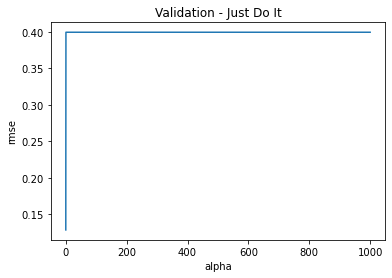

In [48]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
cv_lasso = [-cross_val_score(Lasso(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

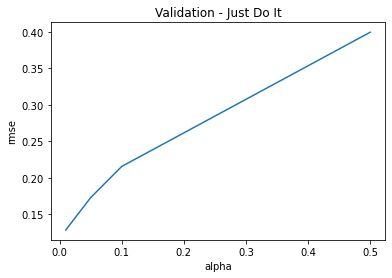

In [50]:
alphas = [0.01, 0.05, 0.1, 0.5]
cv_lasso = [-cross_val_score(Lasso(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

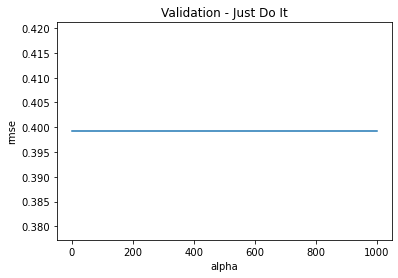

In [51]:
alphas = [1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
cv_lasso = [-cross_val_score(Lasso(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [ ]:
%%time
lasso_param_grid = {
    'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100]
}

lasso_gs = modeling.get_lasso_regression_model(train_model_data_final, y_train, lasso_param_grid)
lasso = Lasso(**lasso_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, lasso)
lasso_gs.best_params_

In [ ]:
%%time
lasso = lasso.fit(train_scaled_data, y_train)
test_pred = lasso.predict(scaler.transform(test_model_data))
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('lasso_predicted_skew_corrected.csv', index=False)

### Ridge Regression

In [72]:
%%time
ridge_param_grid = {
    'alpha':[0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

Fitting 5 folds for each of 19 candidates, totalling 95 fits
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.01; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END .........................................alpha=0.05; total time=   0.0s
[CV] END ..........................................alpha=0.1; total time=   0.0s
[CV] END .......................................

{'alpha': 400}

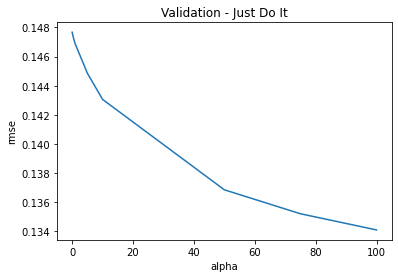

In [41]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100]
cv_ridge = [-cross_val_score(Ridge(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

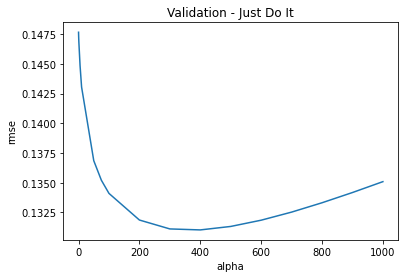

In [42]:
alphas = [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000]
cv_ridge = [-cross_val_score(Ridge(alpha = alpha), scaled_train_data, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = "Validation - Just Do It")
plt.xlabel("alpha")
plt.ylabel("rmse")
plt.show()

In [43]:
(cv_ridge == cv_ridge.min())

0.01       False
0.05       False
0.10       False
0.50       False
1.00       False
5.00       False
10.00      False
50.00      False
75.00      False
100.00     False
200.00     False
300.00     False
400.00      True
500.00     False
600.00     False
700.00     False
800.00     False
900.00     False
1000.00    False
dtype: bool

In [52]:
cv_ridge

0.01       0.147667
0.05       0.147624
0.10       0.147572
0.50       0.147224
1.00       0.146874
5.00       0.144855
10.00      0.143058
50.00      0.136854
75.00      0.135209
100.00     0.134100
200.00     0.131859
300.00     0.131110
400.00     0.131027
500.00     0.131319
600.00     0.131845
700.00     0.132526
800.00     0.133313
900.00     0.134175
1000.00    0.135091
dtype: float64

In [ ]:
%%time
ridge_param_grid = {
    'alpha':[350, 375, 400, 425, 450]
}
ridge_gs = modeling.get_ridge_regressor_model(train_model_data_final, y_train, ridge_param_grid)
ridge = Ridge(**ridge_gs.best_params_)
scaler = StandardScaler().fit(train_model_data_final, y_train)
train_scaled_data = scaler.transform(train_model_data_final)
modeling.evaluate(train_scaled_data, y_train, ridge)
ridge_gs.best_params_

### Elastic Net Regressor


In [54]:
%%time
elastic_net_param_grid = {
    'alpha': [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 75, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
    'l1_ratio':[0.01, 0.05, 0.1, 0.5, 1]
}

elastic_net_model = modeling.get_elastic_net_regressor_model(train_model_data_final, y_train, elastic_net_param_grid)
best_elastic_net_model = ElasticNet(**elastic_net_model.best_params_)
modeling.evaluate(StandardScaler().fit_transform(train_model_data_final), y_train, best_elastic_net_model)
elastic_net_model.best_params_

Fitting 5 folds for each of 95 candidates, totalling 475 fits
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.01; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ..........................alpha=0.01, l1_ratio=0.05; total time=   0.0s
[CV] END ...........................alpha=0.01, l1_ratio=0.1; total time=   0.0s
[CV] END ...........................alpha=0.01,

[CV] END .............................alpha=1, l1_ratio=0.05; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.1; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=1, l1_ratio=0.5; total time=   0.0s
[CV] END ................................alpha=1, l1_ratio=1; total time=   0.0s
[CV] END ...................

[CV] END ............................alpha=100, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=100, l1_ratio=0.5; total time=   0.0s
[CV] END ............................alpha=100, l1_ratio=0.5; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=100, l1_ratio=1; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=200, l1_ratio=0.01; total time=   0.0s
[CV] END ...................

[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ..............................alpha=500, l1_ratio=1; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.01; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.05; total time=   0.0s
[CV] END ...........................alpha=600, l1_ratio=0.05; total time=   0.0s
[CV] END ...................

mean RMSE = 0.12437102841406707, std RMSE = 0.016810853072299275
CPU times: total: 5.14 s
Wall time: 3.31 s


{'alpha': 0.05, 'l1_ratio': 0.1}

In [87]:
elastic_net_model.best_params_

{'alpha': 0.05, 'l1_ratio': 0.1}

### KNN Regressor

In [ ]:
%%time

knn_param_grid = {
    'weights' : ['uniform', 'distance'],
    'algorithm' : ['brute', 'ball_tree', 'kd_tree'],
    'n_neighbors' : [10*i for i in range(1,3)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [i for i in range(1,3)],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)
knn_grid_search.best_params_

In [55]:
%%time

knn_param_grid = {
    'weights' : ['uniform'],
    'algorithm' : ['auto'],
    'n_neighbors' : [5,10,15, 20, 25, 30],
    'leaf_size': [20],
    'p': [1],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
modeling.evaluate(train_model_data_final, y_train, knn_regressor)
knn_grid_search.best_params_

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\model_selection\_search.py:306: UserWarning: The total space of parameters 6 is smaller than n_iter=50. Running 6 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=5, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; total time=   0.0s
[CV] END algorithm=auto, leaf_size=20, n_neighbors=10, p=1, weights=uniform; tota

{'weights': 'uniform',
 'p': 1,
 'n_neighbors': 5,
 'leaf_size': 20,
 'algorithm': 'auto'}

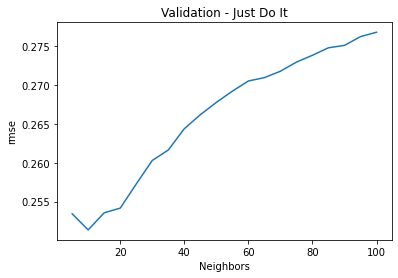

5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [63]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
cv_knn.min()
cv_knn == cv_knn.min() # 10 neighbors

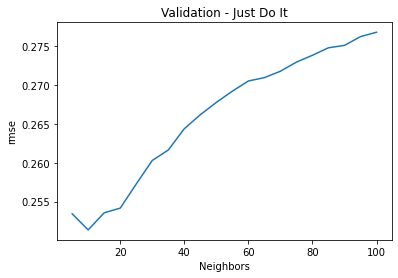

0.2513646469298177


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [65]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, weights='uniform', leaf_size=20, algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

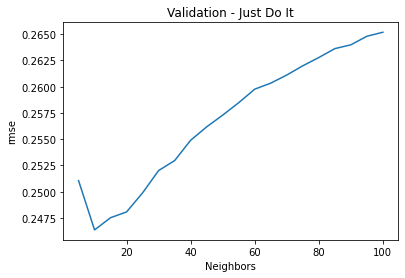

0.24636792411533887


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [66]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

### Changed leaf size to 20 and to euclidean distance

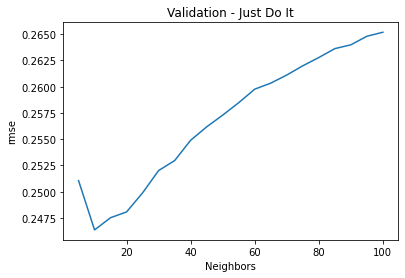

0.24636792411533887


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [68]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, leaf_size=20, p=2, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

### Changed leaf size to 40

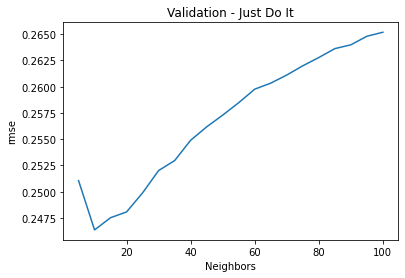

0.24636792411533887


5      False
10      True
15     False
20     False
25     False
30     False
35     False
40     False
45     False
50     False
55     False
60     False
65     False
70     False
75     False
80     False
85     False
90     False
95     False
100    False
dtype: bool

In [69]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, leaf_size=40, p=2, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

In [ ]:
n_neighbors = [i for i in range(5, 105, 5)]
cv_knn = [-cross_val_score(KNeighborsRegressor(n_neighbors = n, leaf_size=40, weights='distance', algorithm='auto'), train_model_data_final, y_train, scoring='neg_root_mean_squared_error', cv=5).mean() 
            for n in n_neighbors]
cv_knn = pd.Series(cv_knn, index = n_neighbors)
cv_knn.plot(title = "Validation - Just Do It")
plt.xlabel("Neighbors")
plt.ylabel("rmse")
plt.show()
print(cv_knn.min())
cv_knn == cv_knn.min() #  neighbors

In [ ]:
%%time

knn_param_grid = {
    'weights' : ['uniform'],
    'algorithm' : ['auto'],
    'n_neighbors' : [5*i for i in range(2,11)],
    'leaf_size': [10*i for i in range(1,3)],
    'p': [1],
}


knn_grid_search = modeling.get_knn_regressor_model(train_model_data_final, y_train, knn_param_grid)
knn_regressor = KNeighborsRegressor(**knn_grid_search.best_params_)
knn_grid_search.best_params_
#modeling.evaluate(train_model_data_final, y_train, knn_regressor)

### XGB Stacking Regressor

In [ ]:
{'alpha': 0.05, 'l1_ratio': 0.08}

In [ ]:
%%time
estimators = [
     ('KNN', KNeighborsRegressor(n_neighbors=10, leaf_size=10)),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.08)),
    ('RandomForestRegressor', RandomForestRegressor())
]

final_estimator=XGBRegressor(**xgb_model.best_params_)

stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)

modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

In [ ]:
try with Cross Validation

In [ ]:
type(test_model_data)

In [ ]:
get_column(test_model_data, 'MSSubClass')

In [ ]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_xgb_predicted_skew_corrected.csv', index=False)

### Random Forest Stacking Regressor

In [70]:
%%time
estimators = [
 ('KNN', KNeighborsRegressor(n_neighbors=10, leaf_size=10)),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.08)),
    ('XGBRegressor', XGBRegressor(**xgb_model.best_params_))
]



final_estimator=RandomForestRegressor()
stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)
modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

mean RMSE = 0.1341831595587502, std RMSE = 0.012155162090374776
CPU times: total: 56.4 s
Wall time: 11 s


In [73]:
%%time
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected.csv', index=False)

CPU times: total: 13.6 s
Wall time: 2.51 s


For xgb best model v3

In [81]:
%%time
estimators = [
    ('LinearRegressor', LinearRegression()),
 ('KNN', KNeighborsRegressor(n_neighbors = 10, leaf_size=20, p=2, weights='distance', algorithm='auto')),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.1)),
    ('XGBRegressor', XGBRegressor(**xgb_best_model_v3))
]



final_estimator=RandomForestRegressor()
stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)
modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

mean RMSE = 0.12569277447819788, std RMSE = 0.013440587595558873
CPU times: total: 2min 1s
Wall time: 28.9 s


In [82]:
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected_v3.csv', index=False)

For xgb v4

In [85]:
%%time
estimators = [
    ('LinearRegressor', LinearRegression()),
 ('KNN', KNeighborsRegressor(n_neighbors = 10, leaf_size=20, p=2, weights='distance', algorithm='auto')),
    ('Lasso', Lasso(alpha=0.01)),
    ('Ridge', Ridge(alpha=400)),
    ('Elastic', ElasticNet(alpha=0.05, l1_ratio=0.1)),
    ('XGBRegressor', XGBRegressor(**xgb_best_model_v4))
]



final_estimator=RandomForestRegressor()
stacking_regressor = modeling.get_stacking_regressor(train_model_data_final, y_train, estimators, final_estimator)
modeling.evaluate(train_model_data_final, y_train, stacking_regressor)

mean RMSE = 0.1262755009640557, std RMSE = 0.011488735209622751
CPU times: total: 1min 5s
Wall time: 13 s


In [86]:
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)
test_pred = stacking_regressor.predict(test_model_data)
test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('stacking_regressor_rf_predicted_skew_corrected_v4.csv', index=False)

## Blending Models

In [88]:
stacking_regressor = stacking_regressor.fit(train_model_data_final, y_train)

knn_regressor = KNeighborsRegressor(n_neighbors = 10, leaf_size=20, p=2, weights='distance', algorithm='auto')\
.fit(train_model_data_final, y_train)

ridge = Ridge(**ridge_gs.best_params_)
train_scaled_data = scaler.transform(train_model_data_final)
scaler = StandardScaler().fit(train_scaled_data, y_train)
ridge = ridge.fit(train_scaled_data, y_train)

lasso = Lasso(**lasso_gs.best_params_)
lasso = lasso.fit(train_scaled_data, y_train)

elastic_net = ElasticNet(**elastic_net_model.best_params_)
elastic_net = elastic_net.fit(train_scaled_data, y_train)

linear_regressor = LinearRegression().fit(train_model_data_final, y_train)

xgb_regressor = XGBRegressor(**xgb_best_model_v3).fit(train_model_data_final, y_train)

In [89]:
from sklearn.metrics import mean_squared_error

In [92]:
 y_pred = ((0.15 * stacking_regressor.predict(train_model_data_final)) + \
            (0.1 * knn_regressor.predict(train_model_data_final)) + \
            (0.15 * elastic_net.predict(train_model_data_final)) + \
            (0.15 * ridge.predict(train_model_data_final)) + \
            (0.15 * lasso.predict(train_model_data_final)) + \
            (0.15 * linear_regressor.predict(train_model_data_final)) + \
            (0.15 * xgb_regressor.predict(train_model_data_final))
            )

C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but ElasticNet was fitted without feature names
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Ridge was fitted without feature names
  warnings.warn(
C:\Users\Nikhil\anaconda3\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but Lasso was fitted without feature names
  warnings.warn(


In [99]:
def blended_predictions(X, dataset='train'):
    y_pred = ((0.15 * stacking_regressor.predict(X)) + \
            (0.1 * knn_regressor.predict(X)) + \
            (0.15 * elastic_net.predict(train_scaled_data)) + \
            (0.15 * ridge.predict(train_scaled_data)) + \
            (0.15 * lasso.predict(train_scaled_data)) + \
            (0.15 * linear_regressor.predict(X)) + \
            (0.15 * xgb_regressor.predict(X))
            )
    
    if dataset == 'train':
        rmsle = np.sqrt(mean_squared_error(y_train, y_pred))
    else:
        rmsle = -1
    return y_pred, rmsle

In [100]:
train_pred, train_rmsle = blended_predictions(train_model_data_final)
train_pred, train_rmsle

(array([12.23717027, 12.10079283, 12.27603491, ..., 12.46745581,
        11.82064536, 11.85587658]),
 0.08368242386818714)

In [129]:
train_pred = ((0.4 * stacking_regressor.predict(train_model_data_final)) + \
            (0.1 * knn_regressor.predict(train_model_data_final)) + \
            (0.1 * elastic_net.predict(train_scaled_data)) + \
            (0.1 * ridge.predict(train_scaled_data)) + \
            (0.1 * lasso.predict(train_scaled_data)) + \
            (0.1 * linear_regressor.predict(train_model_data_final)) + \
            (0.1 * xgb_regressor.predict(train_model_data_final))
            )

train_rmsle = np.sqrt(mean_squared_error(y_train, train_pred))
train_rmsle

0.07788998859818715

In [122]:
test_scaled_data = scaler.transform(test_model_data)

test_pred = ((0.15 * stacking_regressor.predict(test_model_data)) + \
            (0.1 * knn_regressor.predict(test_model_data)) + \
            (0.15 * elastic_net.predict(test_scaled_data)) + \
            (0.15 * ridge.predict(test_scaled_data)) + \
            (0.15 * lasso.predict(test_scaled_data)) + \
            (0.15 * linear_regressor.predict(test_model_data)) + \
            (0.15 * xgb_regressor.predict(test_model_data))
            )

test_pred = np.expm1(test_pred)
test_df['PredictedSalePrice'] = test_pred
pred = test_df[['Id', 'PredictedSalePrice']]
columns = dict()
columns['PredictedSalePrice'] = 'SalePrice'
pred = pred.rename(columns=columns)
pred.to_csv('blended_skew_corrected_v1.csv', index=False)

In [115]:
train_pred

array([12.23717027, 12.10079283, 12.27603491, ..., 12.46745581,
       11.82064536, 11.85587658])

In [123]:
pd.Series(train_pred).describe()

count    1460.000000
mean       12.010621
std         0.375209
min        10.627817
25%        11.758314
50%        11.993564
75%        12.255892
max        13.353584
dtype: float64

In [124]:

pd.Series(test_pred).describe()

count      1459.000000
mean     175698.507622
std       70750.483244
min       47498.822198
25%      126767.427412
50%      156481.398639
75%      206502.647502
max      482089.070187
dtype: float64

In [101]:
test_pred, test_rmsle = blended_predictions(test_model_data, dataset='test')

ValueError: operands could not be broadcast together with shapes (1459,) (1460,) 